In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
np.set_printoptions(suppress=True)

%reload_ext autoreload
%autoreload 2

In [5]:
from clonaltrans import pl, utils
from clonaltrans.bootstrap import Bootstrapping
import os
from tqdm import tqdm

### Origianl Dataset

In [4]:
path = './rawdatas/rawdata_dynamic_novar_l2norm.pt'
model = torch.load(path)
device = torch.device(f"cuda:{model.config.gpu}")

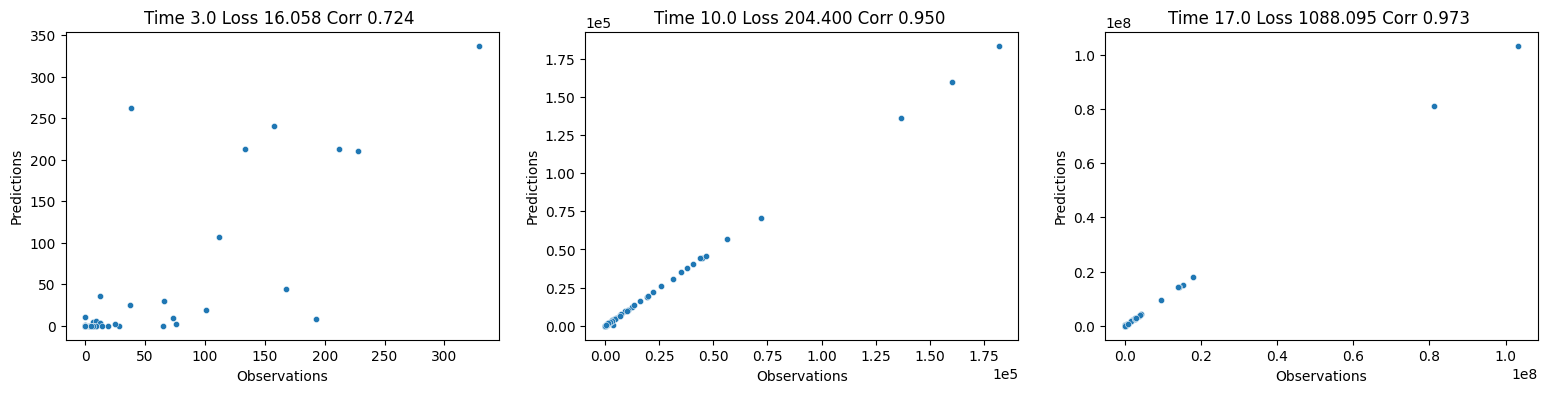

In [5]:
from torch.nn.parameter import Parameter
t_observed = torch.tensor([0.0, 3.0, 10.0, 17.0]).to(device)

predictions = model.eval_model(t_observed, log_output=False)
save = 'eval_' + os.path.split(path)[1]
pl.mse_corr(model.N, torch.pow(predictions, 4), t_observed, save=False, sample_N=torch.ones(model.N.shape))

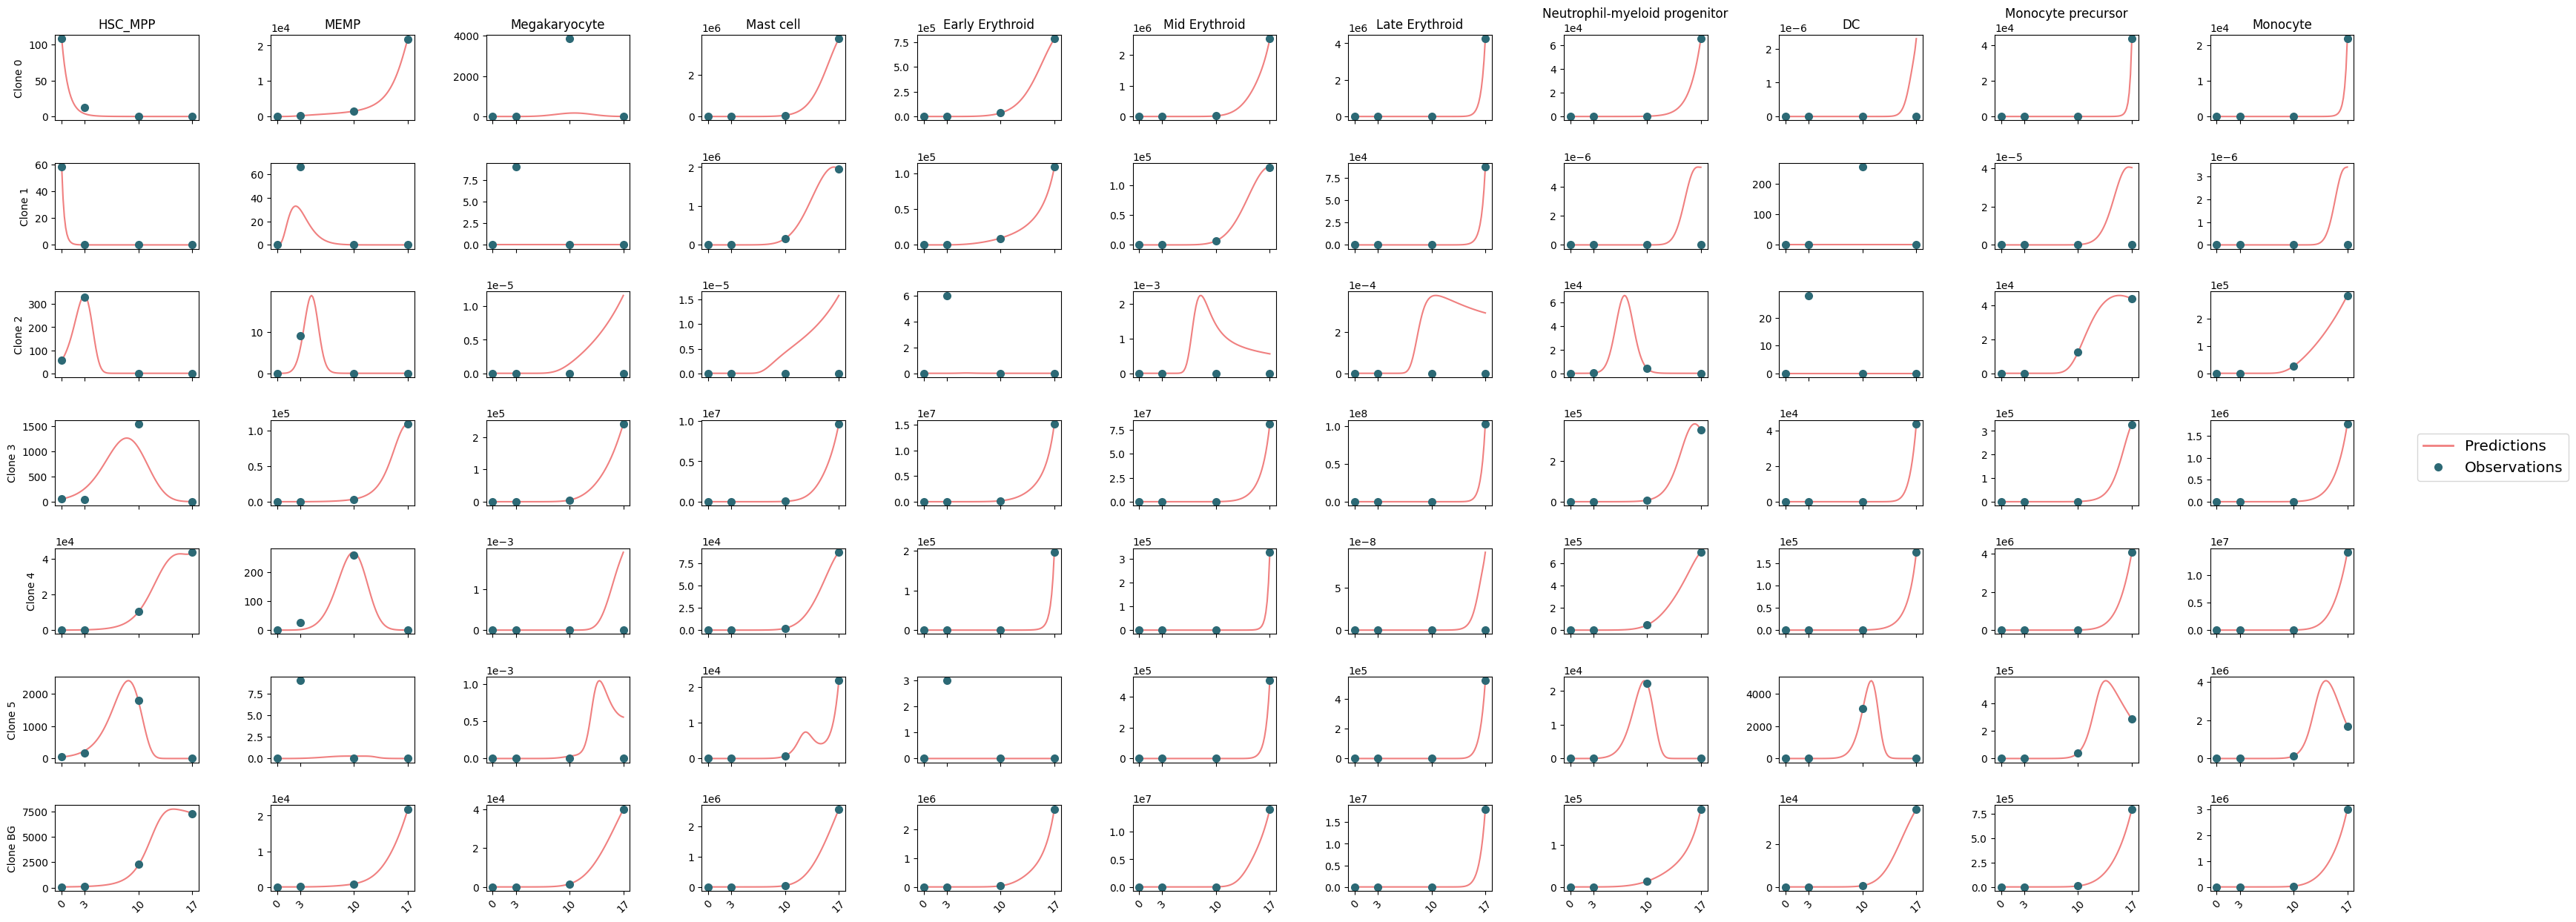

In [6]:
pl.grid_visual_interpolate(
    model,
    raw_data=True,
)

In [6]:
pl.clone_dynamic_K(model, 'dynamic', 0, suffix='4tps')

### Simulation of 10 time points

In [4]:
t_observed = torch.tensor([0.0, 1.0, 3.0, 6.0, 9.0, 10.0, 12.0, 14.0, 16.0, 17.0]).to(device)
predictions = model.eval_model(t_observed, log_output=False)

In [5]:
predictions = torch.pow(predictions, 4)
predictions = torch.swapaxes(predictions.cpu(), 0, 1)[:-1, 1:, :].numpy()
predictions = predictions.reshape(6, 99)
np.savetxt('./data/V4_10tpoint/kinetics_array_correction_factor.txt', predictions)

### Performance of 10 time points

In [8]:
path = './data/V4_10tpoint/dynamic_novar.pt'
model = torch.load(path)
device = torch.device(f"cuda:{model.config.gpu}")
t_observed = torch.tensor([0.0, 1.0, 3.0, 6.0, 9.0, 10.0, 12.0, 14.0, 16.0, 17.0]).to(device)

/data/users/mingzegao/.conda/envs/pytorch/lib/python3.8/site-packages/torchdiffeq/_impl/misc.py:296: UserWarning: t is not on the same device as y0. Coercing to y0.device.
  warnings.warn("t is not on the same device as y0. Coercing to y0.device.")


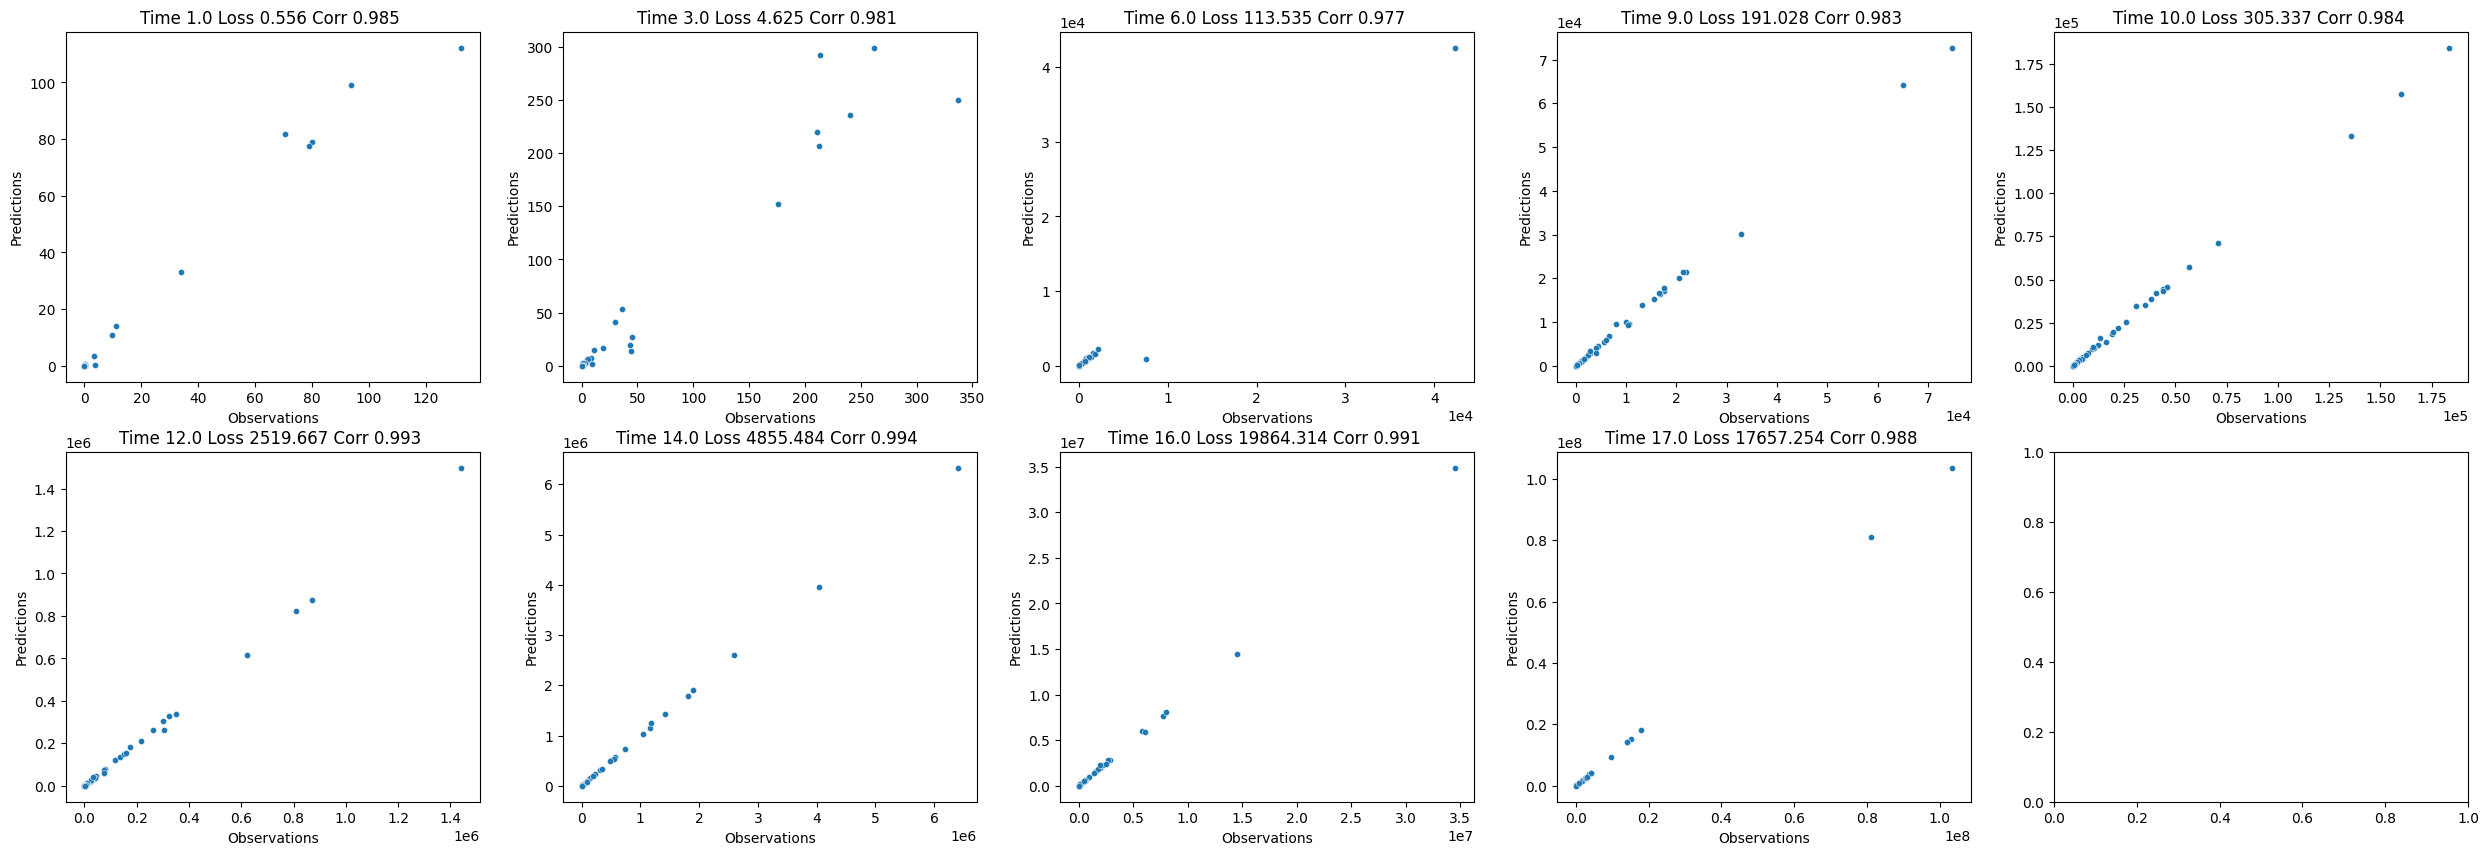

In [13]:
from torch.nn.parameter import Parameter

predictions = model.eval_model(t_observed, log_output=False)
save = 'eval_' + os.path.split(path)[1]
pl.mse_corr(model.N, torch.pow(predictions, 4), t_observed, save='sime10tps', sample_N=torch.ones(model.N.shape))

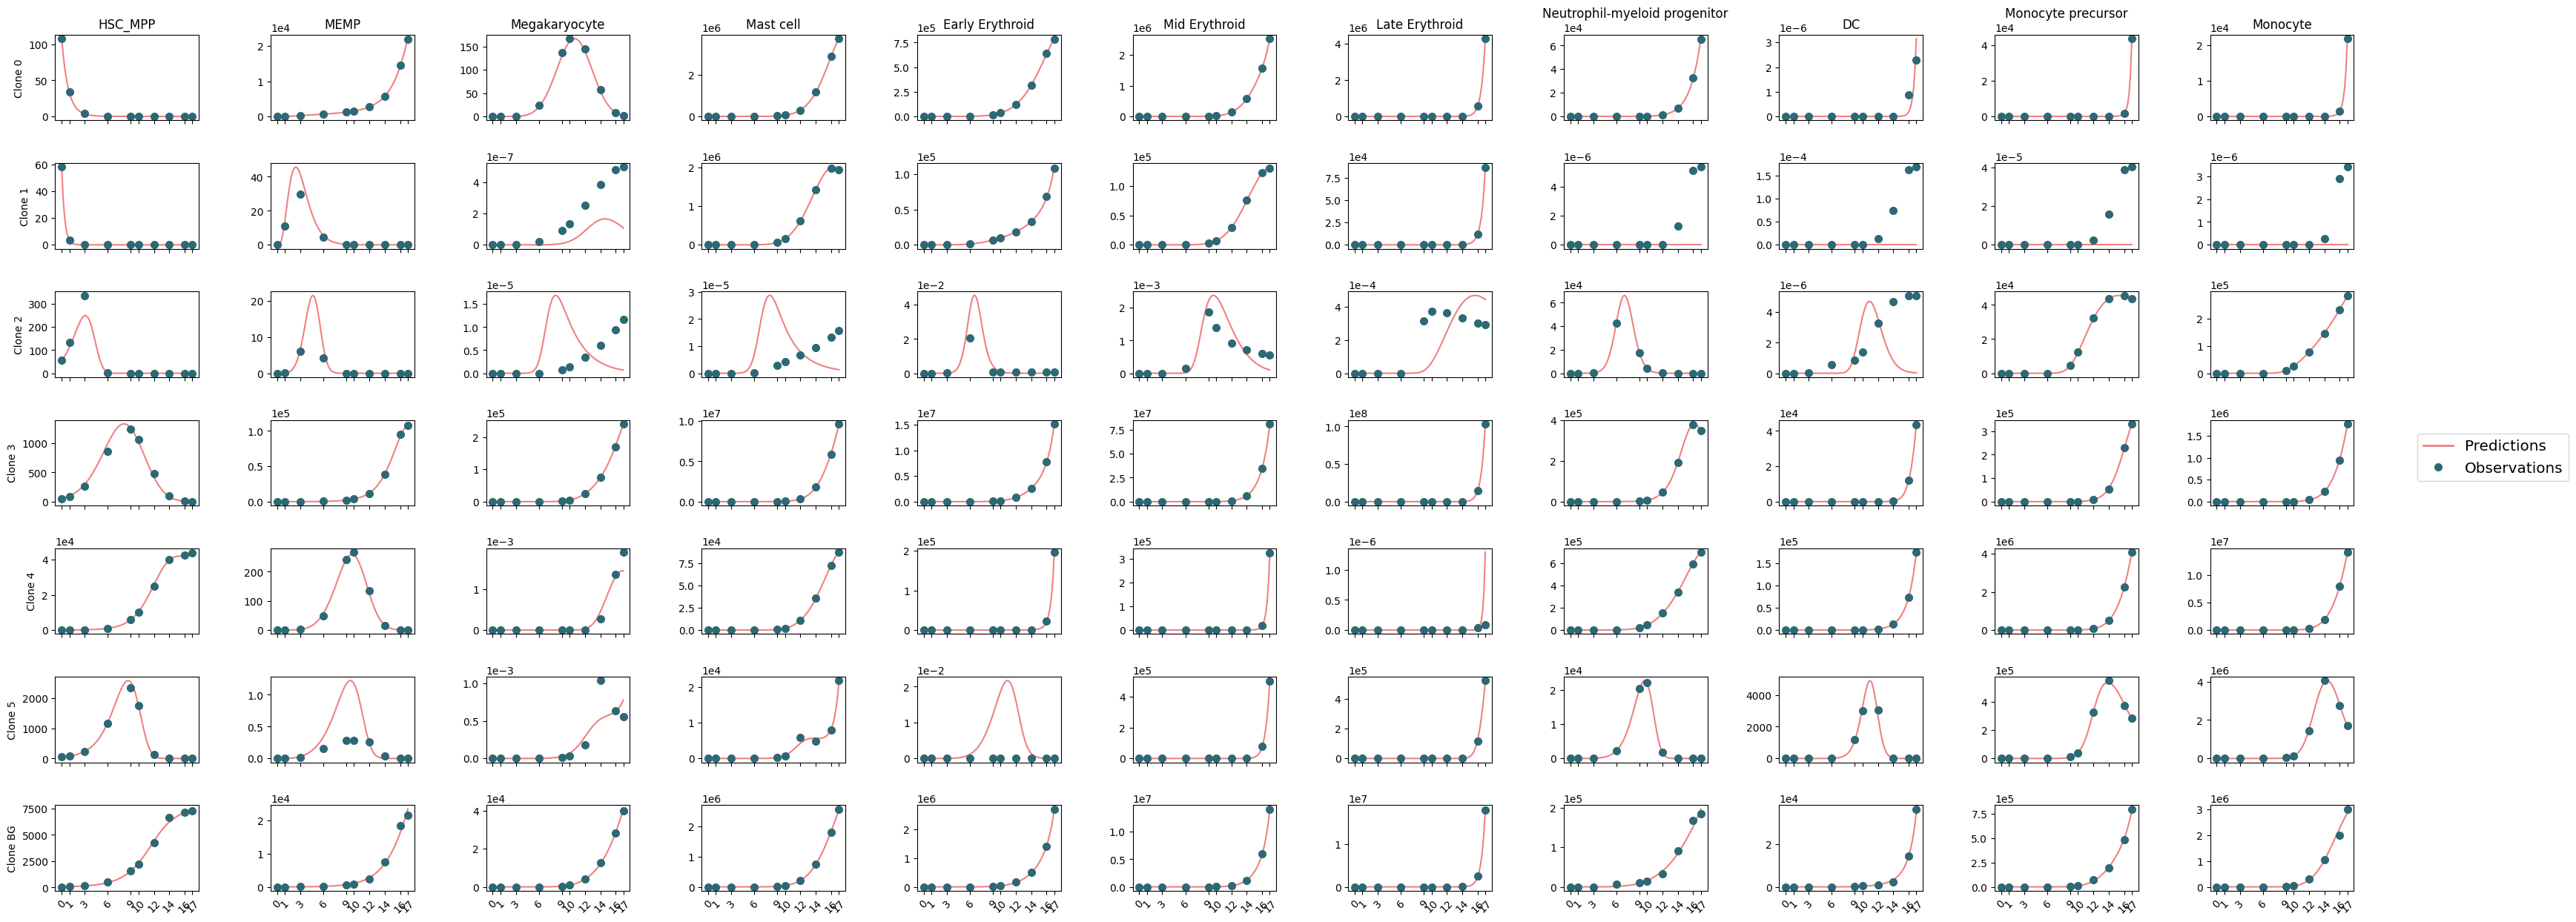

In [14]:
pl.grid_visual_interpolate(
    model,
    raw_data=True,
    save='curvesimu10tps'
)

In [ ]:
pl.clone_dynamic_K(model, 'dynamic', 0, suffix='10tps')

### Bootstrapping

In [10]:
path = './data/V4_10tpoint/dynamic_novar.pt'
dyna = torch.load(path)
t_observed = torch.tensor([0.0, 1.0, 3.0, 6.0, 9.0, 10.0, 12.0, 14.0, 16.0, 17.0]).to('cpu')

In [8]:
model_list = []

for name in tqdm(os.listdir('./dyna_boots10tps/')):
    temp = torch.load(f'./dyna_boots10tps/{name}')
    model_list.append(temp)

print (len(model_list))

100%|██████████| 569/569 [00:41<00:00, 13.78it/s]

569


In [11]:
for idx, model in enumerate(model_list):
    if idx >= 5 and idx <= 10:
        predictions = model.eval_model(t_observed, log_output=False)

        save = 'eval_' + os.path.split(path)[1]
        pl.mse_corr(model.N, torch.pow(predictions, 4), t_observed, 
                    save=False, sample_N=model.sample_N, verbose=True)

Time 1.0 Loss 0.000 Corr 0.985 Time 3.0 Loss 4.557 Corr 0.926 Time 6.0 Loss 52.018 Corr 0.984 Time 9.0 Loss 131.695 Corr 0.991 Time 10.0 Loss 228.062 Corr 0.997 Time 12.0 Loss 1358.219 Corr 0.985 Time 14.0 Loss 2072.658 Corr 0.999 Time 16.0 Loss 1214.751 Corr 1.000 Time 17.0 Loss 150.206 Corr 1.000 
Time 1.0 Loss 1.540 Corr 0.966 Time 3.0 Loss 6.679 Corr 0.981 Time 6.0 Loss 345.821 Corr 0.984 Time 9.0 Loss 2832.519 Corr 0.992 Time 10.0 Loss 1596.311 Corr 0.990 Time 12.0 Loss 2933.542 Corr 0.998 Time 14.0 Loss 2866.364 Corr 0.999 Time 16.0 Loss 80853.781 Corr 0.990 Time 17.0 Loss 2656.470 Corr 0.998 
Time 1.0 Loss 1.276 Corr 0.997 Time 3.0 Loss 0.830 Corr 0.991 Time 6.0 Loss 3.113 Corr 0.997 Time 9.0 Loss 157.082 Corr 0.998 Time 10.0 Loss 114.497 Corr 1.000 Time 12.0 Loss 692.233 Corr 0.999 Time 14.0 Loss 1427.008 Corr 0.998 Time 16.0 Loss 911.632 Corr 0.998 Time 17.0 Loss 163.560 Corr 0.996 
Time 1.0 Loss 0.000 Corr 1.000 Time 3.0 Loss 4.519 Corr 0.996 Time 6.0 Loss 5.439 Corr 0.995 Ti

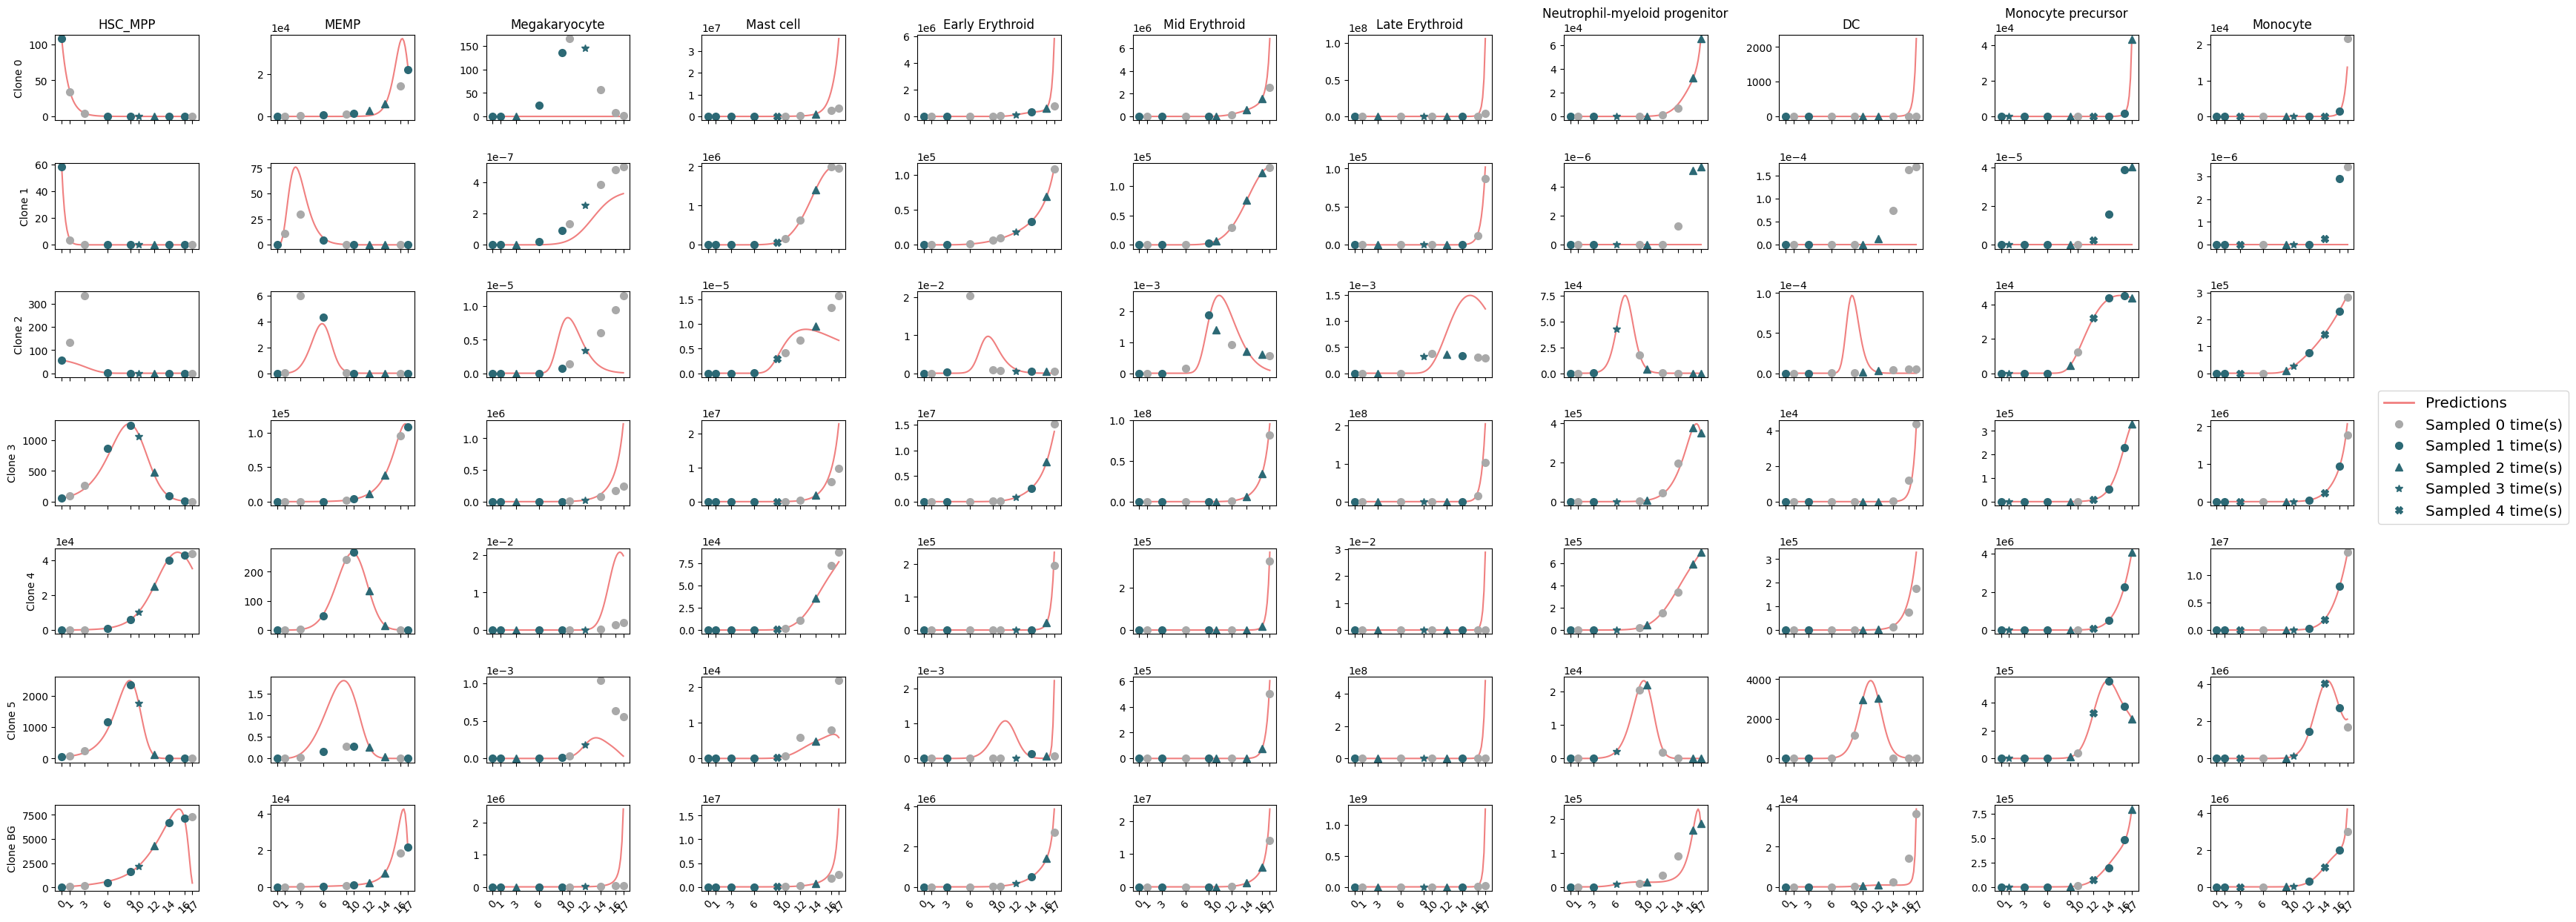

In [13]:
for idx, model in enumerate(model_list):
    if idx == 5:
        pl.grid_visual_interpolate(
            model,
            raw_data=True,
            save='exampleboots10'
        )

In [16]:
total_K, ref_K = pl.parameter_range(model_list, 'dynamic', 3.0, ref_model=dyna)

100%|██████████| 569/569 [00:43<00:00, 12.97it/s]


In [23]:
pl.parameter_ci(total_K, dyna.data_dir, 2, pop_1=2, pop_2=2, ref_K=ref_K, save='2mega')

In [24]:
pl.parameter_ci(total_K, dyna.data_dir, 2, pop_1=7, pop_2=9, ref_K=ref_K, save='2nmpmp')

In [25]:
total_pred, obs, t_smoothed = pl.trajectory_range(model_list, dyna, raw_data=True)

570it [03:24,  2.79it/s]


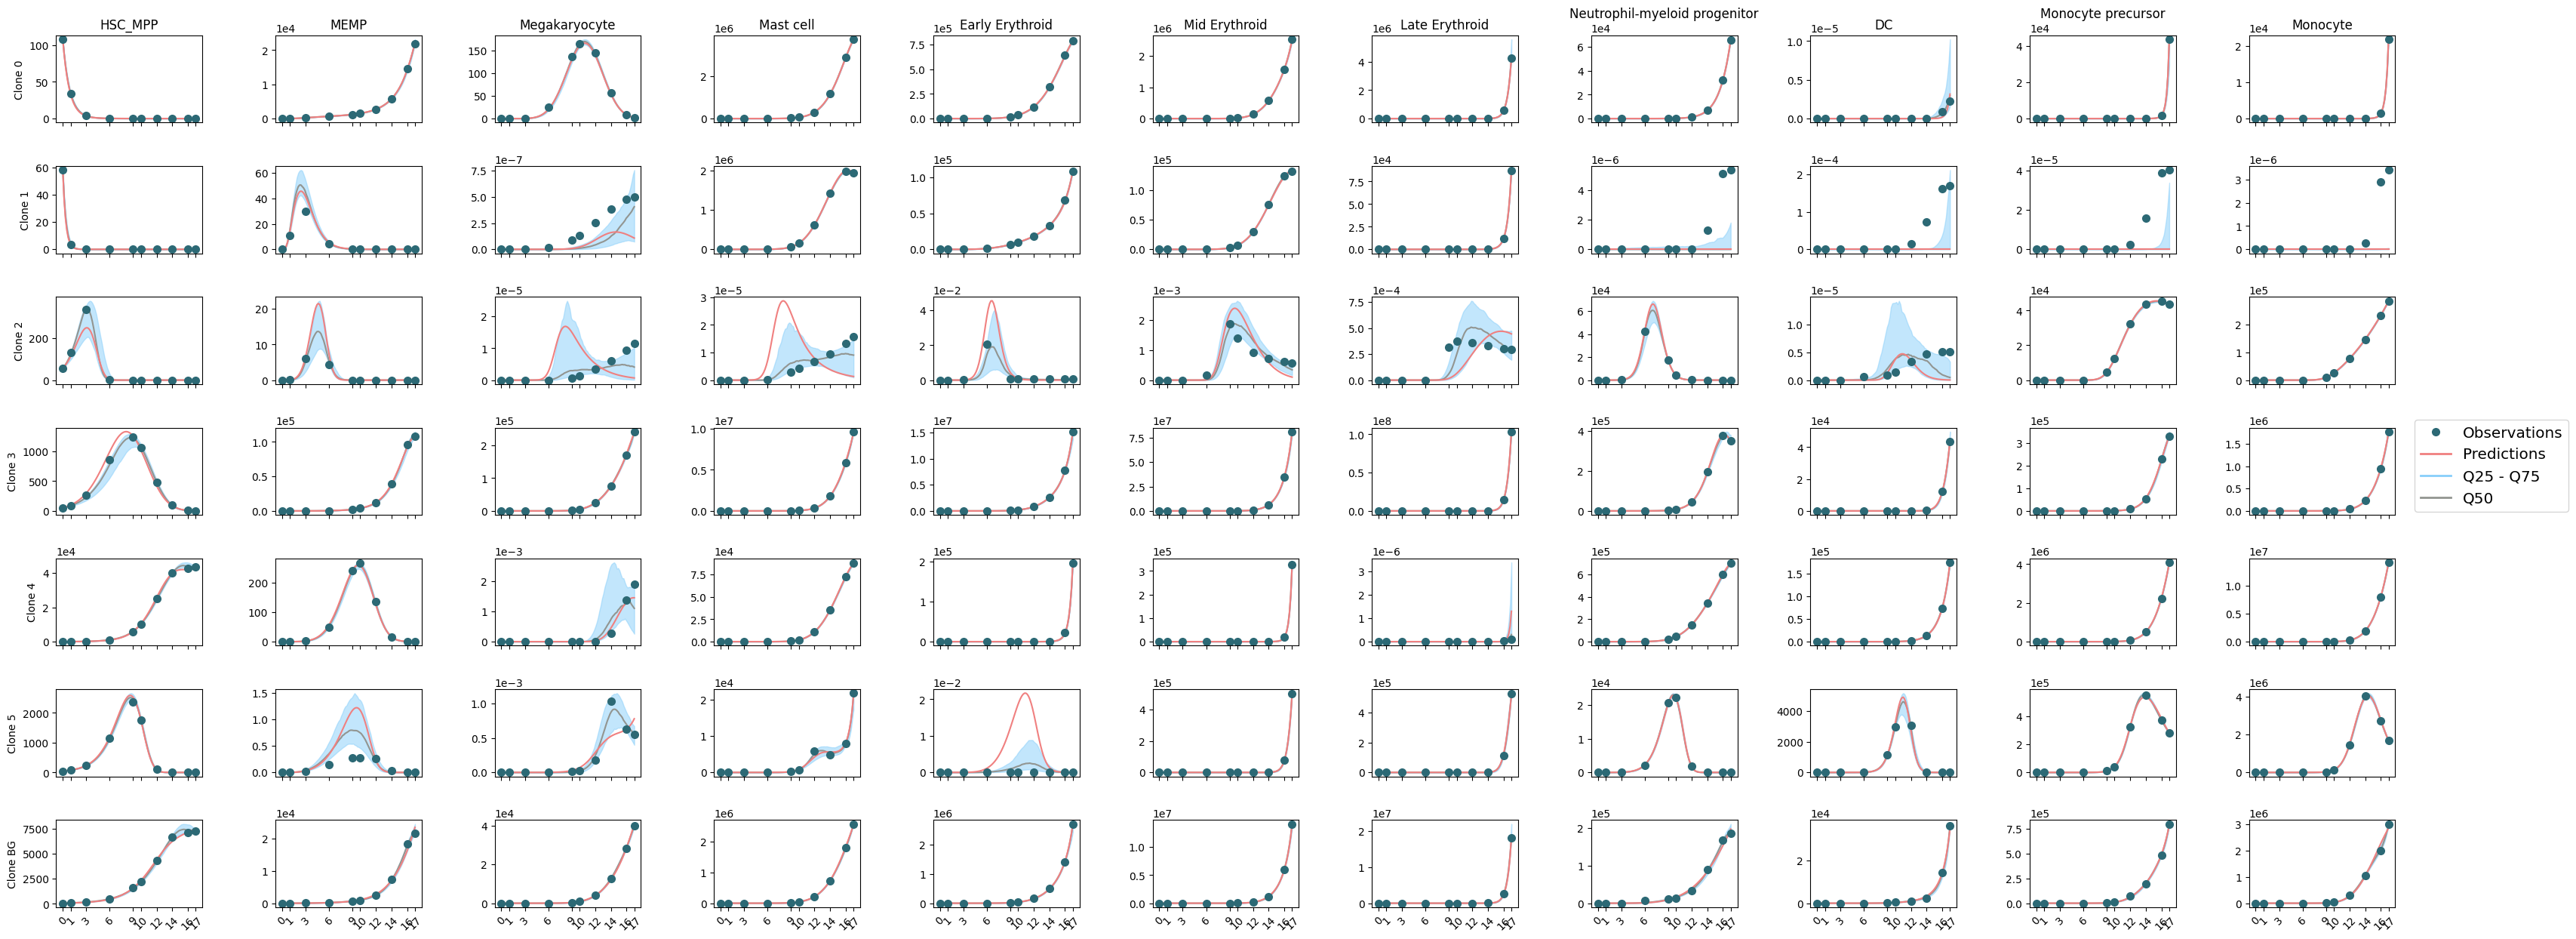

In [29]:
pl.trajectory_ci(total_pred, obs, t_smoothed, dyna, boundary=[25, 75], save='trajectoryci')